In [1]:
import pandas as pd
import scipy.stats
import numpy as np

df = pd.read_csv('Pulsesurvey_New.csv')
df.head()

,Birthyear,Gender,Hispanic,Race,Education,Maritalstatus,Numkid,Getvacc,Workloss,Expectloss,...,Interest,Down,Hlthins4,Hlthins8,Prescript,Mh_svcs,Mh_notget,Tenure,Teach4,Income
0,1962,2,1,4,4,2,0,3,2,2,...,1,1,1,2,2,2,2,1,-88,-88
1,1941,1,1,1,5,1,0,1,2,2,...,3,3,2,-99,2,2,2,2,-88,4
2,1951,2,1,1,4,3,0,3,2,2,...,3,2,2,2,2,2,2,1,-88,-99
3,1978,1,1,2,3,1,4,2,1,2,...,1,2,1,1,2,2,2,3,-99,3
4,1985,2,1,1,6,1,3,1,2,2,...,-88,-88,-88,-88,-88,-88,-88,-88,-88,-88


In [2]:
df['Birthyear_bins'] = pd.cut(x=df['Birthyear'], bins=[1931, 1951, 1961, 1971, 1981, 1991, 2011])
df['Birthyear_codes'] = pd.cut(x=df['Birthyear'], bins=[1931, 1951, 1961, 1971, 1981, 1991, 2011], labels=[1,2,3,4,5,6])
df_income = df[(df['Income']>0)] 
df['Getvacc_explain'] = df['Getvacc'].replace({1: 'Definitely Yes', 2: 'Probably Yes', 3: 'Probably Not', 4: 'Definitely Not'})
df['Agegroup']=df['Birthyear_codes'].replace({1: 'over 60', 2: '51-60', 3: '41-50', 4:'31-40', 5:'21-30', 6: 'under 20'})
df.head()

,Birthyear,Gender,Hispanic,Race,Education,Maritalstatus,Numkid,Getvacc,Workloss,Expectloss,...,Prescript,Mh_svcs,Mh_notget,Tenure,Teach4,Income,Birthyear_bins,Birthyear_codes,Getvacc_explain,Agegroup
0,1962,2,1,4,4,2,0,3,2,2,...,2,2,2,1,-88,-88,"(1961, 1971]",3,Probably Not,41-50
1,1941,1,1,1,5,1,0,1,2,2,...,2,2,2,2,-88,4,"(1931, 1951]",1,Definitely Yes,over 60
2,1951,2,1,1,4,3,0,3,2,2,...,2,2,2,1,-88,-99,"(1931, 1951]",1,Probably Not,over 60
3,1978,1,1,2,3,1,4,2,1,2,...,2,2,2,3,-99,3,"(1971, 1981]",4,Probably Yes,31-40
4,1985,2,1,1,6,1,3,1,2,2,...,-88,-88,-88,-88,-88,-88,"(1981, 1991]",5,Definitely Yes,21-30


# One-way ANOVA (Income)

In [47]:
import researchpy as rp
rp.summary_cont(df['Income'].groupby(df['Getvacc']))

,N,Mean,SD,SE,95% Conf.,Interval
Getvacc,,,,,,
1,79052,-14.2276,37.9486,0.1350,-14.4921,-13.9630
2,25908,-19.4396,40.6015,0.2522,-19.9340,-18.9451
3,13380,-21.4542,41.4255,0.3581,-22.1562,-20.7522
4,8921,-23.9725,42.5012,0.4500,-24.8546,-23.0905


In [48]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

mod = ols('Getvacc ~ Income', data=df).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)

def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']

    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])

    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
Income,773.095783,1.0,773.095783,899.576134,5.924800e-197,0.007019,0.007011
Residual,109366.392167,127259.0,0.859400,NaN,NaN,NaN,NaN


In [49]:
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(df['Income'], df['Getvacc_explain'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Definitely Not,Definitely Yes,9.745,0.001,8.62,10.87,True
Definitely Not,Probably Not,2.5184,0.001,1.1416,3.8951,True
Definitely Not,Probably Yes,4.533,0.001,3.2965,5.7695,True
Definitely Yes,Probably Not,-7.2266,0.001,-8.1682,-6.285,True
Definitely Yes,Probably Yes,-5.212,0.001,-5.9331,-4.4909,True
Probably Not,Probably Yes,2.0146,0.001,0.9423,3.0869,True


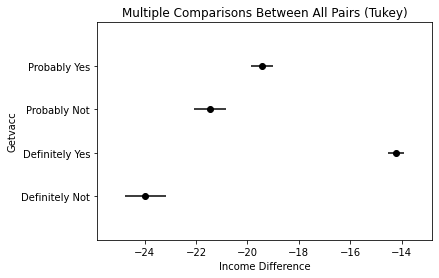

In [52]:
import matplotlib.pyplot as plt
post_hoc_res.plot_simultaneous(ylabel= "Getvacc", xlabel= "Income Difference", figsize = (6,4))
                               
plt.yticks(np.arange(4), ['Definitely Not', 'Definitely Yes', 'Probably Not', 'Probably Yes'])
plt.show()

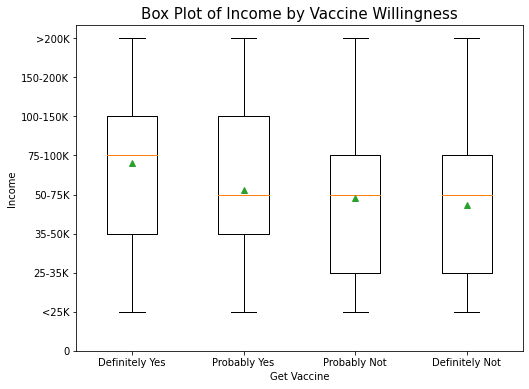

In [33]:
plt.close()
fig = plt.figure(figsize= (8, 6))
ax = fig.add_subplot(111)

ax.set_title("Box Plot of Income by Vaccine Willingness", fontsize= 15)
ax.set

data = [df_income[df_income['Getvacc'] == 1]['Income'], 
        df_income[df_income['Getvacc'] == 2]['Income'], 
        df_income[df_income['Getvacc'] == 3]['Income'],
        df_income[df_income['Getvacc'] == 4]['Income']]

ax.boxplot(data,labels= ['Definitely Yes', 'Probably Yes', 'Probably Not', 'Definitely Not'], showmeans= True)
plt.xlabel("Get Vaccine")
plt.ylabel("Income")
plt.yticks(np.arange(9), ['0', '<25K', '25-35K', '35-50K', '50-75K', '75-100K', '100-150K', '150-200K', '>200K'])

plt.show()

# One-way ANOVA (Education)

In [15]:
rp.summary_cont(df['Education'].groupby(df['Getvacc']))

,N,Mean,SD,SE,95% Conf.,Interval
Getvacc,,,,,,
1,79052,5.4375,1.4231,0.0051,5.4275,5.4474
2,25908,4.9034,1.4614,0.0091,4.8856,4.9212
3,13380,4.7092,1.4117,0.0122,4.6853,4.7331
4,8921,4.5366,1.4389,0.0152,4.5067,4.5665


In [16]:
mod = ols('Getvacc ~ Education', data=df).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
Education,5179.134332,1.0,5179.134332,6279.432503,0.0,0.047023,0.047016
Residual,104960.353618,127259.0,0.824777,NaN,NaN,NaN,NaN


In [37]:
comp = mc.MultiComparison(df['Education'], df['Getvacc_explain'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Definitely Not,Definitely Yes,0.9009,0.001,0.8598,0.9419,True
Definitely Not,Probably Not,0.1726,0.001,0.1223,0.2228,True
Definitely Not,Probably Yes,0.3668,0.001,0.3217,0.4119,True
Definitely Yes,Probably Not,-0.7283,0.001,-0.7626,-0.6939,True
Definitely Yes,Probably Yes,-0.5341,0.001,-0.5604,-0.5078,True
Probably Not,Probably Yes,0.1942,0.001,0.1551,0.2333,True


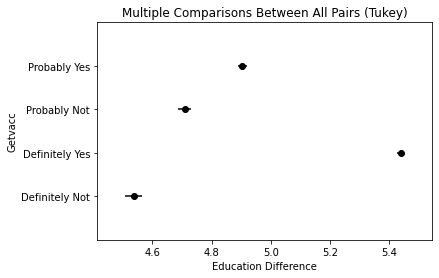

In [39]:
post_hoc_res.plot_simultaneous(ylabel= "Getvacc", xlabel= "Education Difference", figsize = (6,4))
plt.yticks(np.arange(4), ['Definitely Not', 'Definitely Yes', 'Probably Not', 'Probably Yes'])
plt.show()

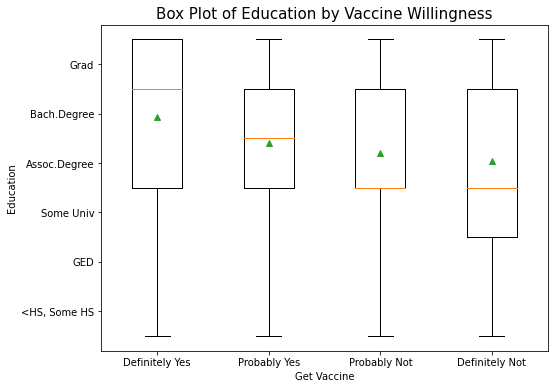

In [25]:
plt.close()
fig = plt.figure(figsize= (8, 6))
ax = fig.add_subplot(111)

ax.set_title("Box Plot of Education by Vaccine Willingness", fontsize= 15)
ax.set

data = [df[df['Getvacc'] == 1]['Education'], 
        df[df['Getvacc'] == 2]['Education'], 
        df[df['Getvacc'] == 3]['Education'],
        df[df['Getvacc'] == 4]['Education']]

ax.boxplot(data,labels= ['Definitely Yes', 'Probably Yes', 'Probably Not', 'Definitely Not'], showmeans= True)
plt.xlabel("Get Vaccine")
plt.ylabel("Education")
plt.yticks(np.arange(1.5, 7.5), ['<HS, Some HS', 'GED', 'Some Univ', 'Assoc.Degree', 'Bach.Degree', 'Grad'])
plt.show()

# One-way ANOVA (Age)

In [42]:
rp.summary_cont(df['Birthyear'].groupby(df['Getvacc']))

,N,Mean,SD,SE,95% Conf.,Interval
Getvacc,,,,,,
1,79052,1965.1299,16.0572,0.0571,1965.0180,1965.2418
2,25908,1971.3810,15.1613,0.0942,1971.1963,1971.5656
3,13380,1973.9958,14.4191,0.1247,1973.7515,1974.2402
4,8921,1974.1317,14.6886,0.1555,1973.8269,1974.4366


In [43]:
mod = ols('Getvacc ~ Birthyear_codes', data=df).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
Birthyear_codes,5606.077842,5.0,1121.215568,1364.925214,0.0,0.0509,0.050862
Residual,104533.410108,127255.0,0.821448,NaN,NaN,NaN,NaN


In [54]:
comp = mc.MultiComparison(df['Birthyear_codes'], df['Getvacc_explain'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Definitely Not,Definitely Yes,-0.8649,0.001,-0.9084,-0.8214,True
Definitely Not,Probably Not,-0.0197,0.7518,-0.0729,0.0335,False
Definitely Not,Probably Yes,-0.2737,0.001,-0.3215,-0.2259,True
Definitely Yes,Probably Not,0.8452,0.001,0.8088,0.8816,True
Definitely Yes,Probably Yes,0.5912,0.001,0.5633,0.6191,True
Probably Not,Probably Yes,-0.254,0.001,-0.2955,-0.2126,True


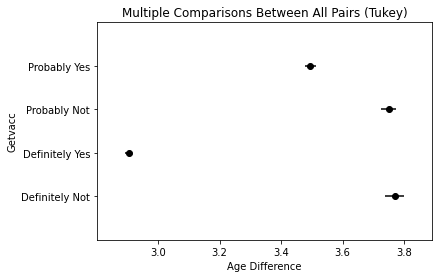

In [55]:
post_hoc_res.plot_simultaneous(ylabel= "Getvacc", xlabel= "Age Difference", figsize = (6,4))
plt.yticks(np.arange(4), ['Definitely Not', 'Definitely Yes', 'Probably Not', 'Probably Yes'])
plt.show()

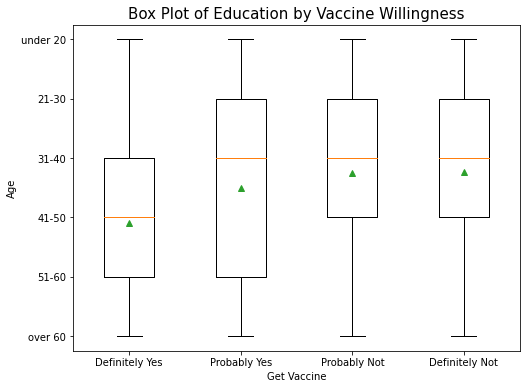

In [27]:
plt.close()
fig = plt.figure(figsize= (8, 6))
ax = fig.add_subplot(111)

ax.set_title("Box Plot of Education by Vaccine Willingness", fontsize= 15)
ax.set

data = [df[df['Getvacc'] == 1]['Birthyear_codes'], 
        df[df['Getvacc'] == 2]['Birthyear_codes'], 
        df[df['Getvacc'] == 3]['Birthyear_codes'],
        df[df['Getvacc'] == 4]['Birthyear_codes']]

ax.boxplot(data,labels= ['Definitely Yes', 'Probably Yes', 'Probably Not', 'Definitely Not'], showmeans= True)
plt.xlabel("Get Vaccine")
plt.ylabel("Age")
plt.yticks(np.arange(1,7), ['over 60', '51-60', '41-50', '31-40', '21-30', 'under 20'])
plt.show()